In [4]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
data = pd.read_csv('conversion_data.csv')

In [6]:
data.sample(n=5)

,country,age,new_user,source,total_pages_visited,converted
254112,US,40,1,Seo,5,0
107610,UK,23,1,Seo,3,0
308208,US,29,1,Seo,11,0
228127,UK,29,1,Direct,10,0
159498,US,32,1,Ads,6,0


In [7]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


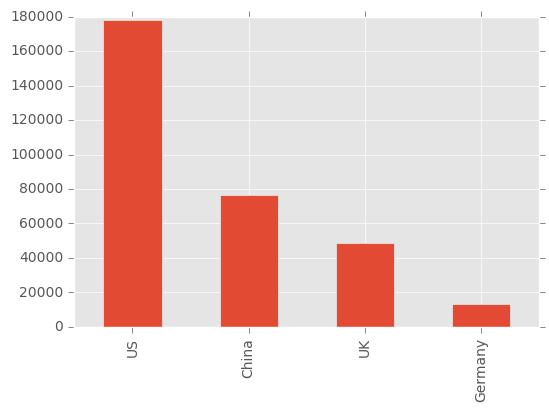

In [8]:
data['country'].value_counts().plot(kind='bar')

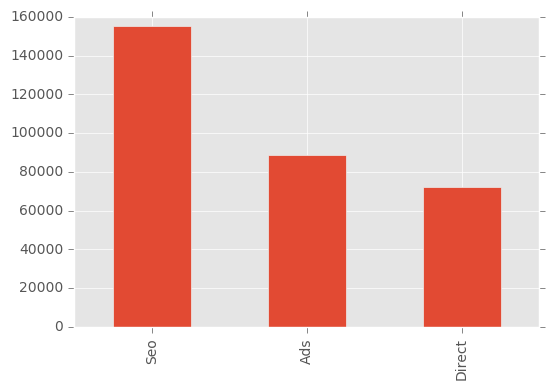

In [9]:
data['source'].value_counts().plot(kind='bar')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1056e46d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113003c88>]], dtype=object)

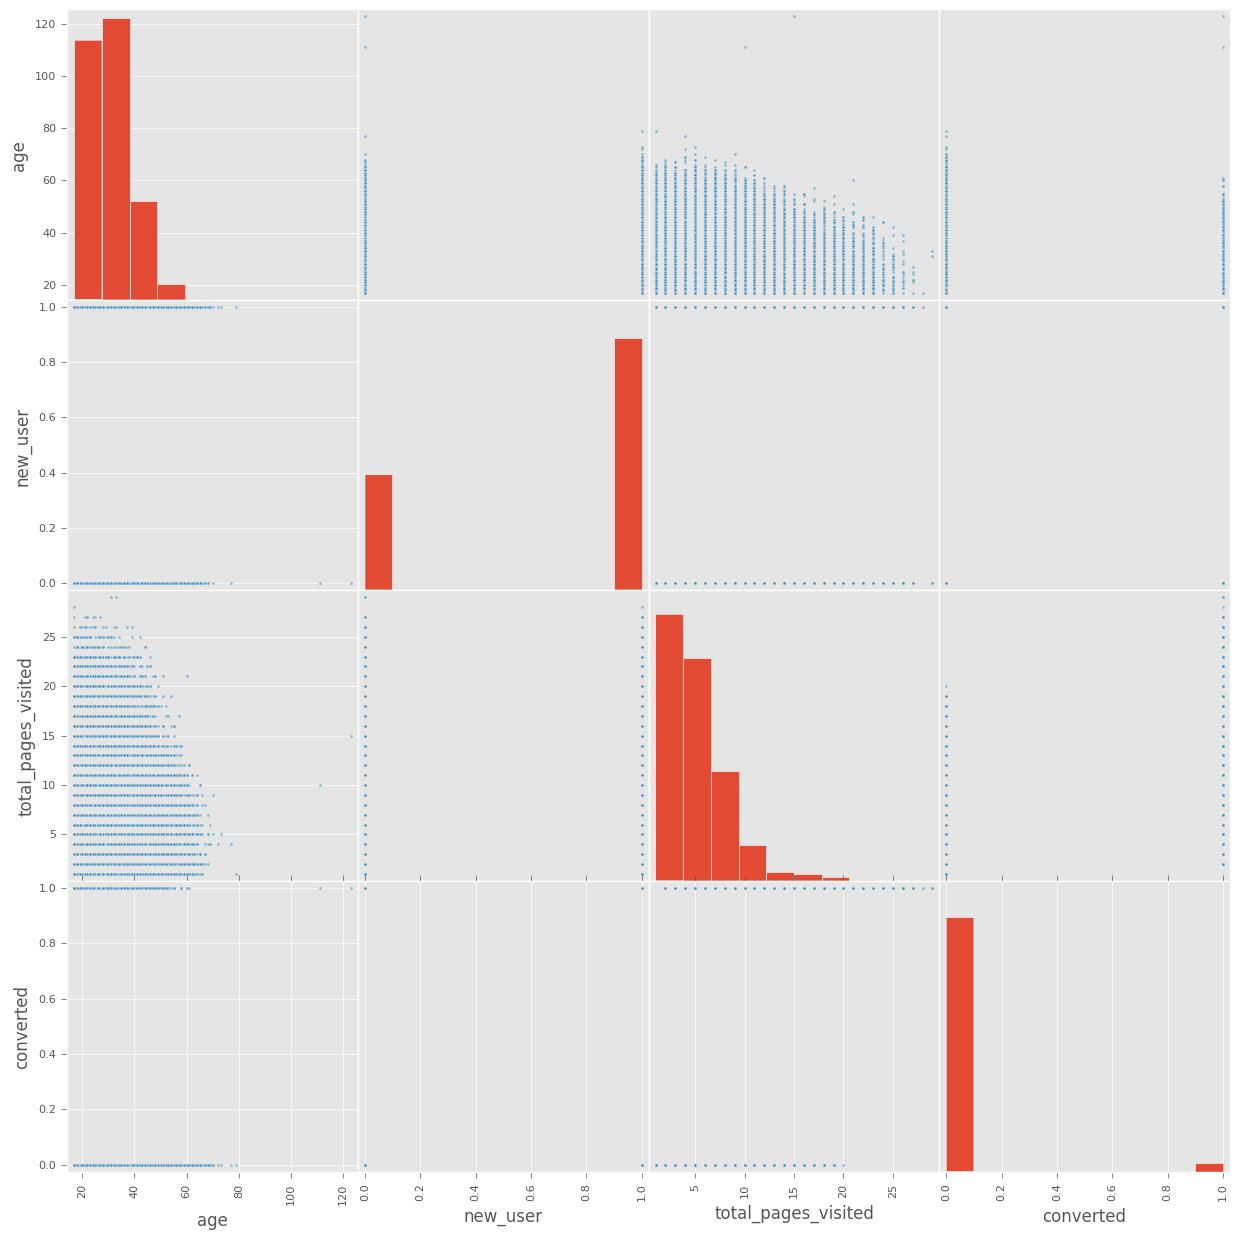

In [10]:
pd.scatter_matrix(data, figsize=(15, 15))

In [11]:
LE = LabelEncoder().fit(data['country'])
country = LE.fit_transform(data['country'])

In [12]:
pd.Series(country).value_counts()

3    178092
0     76602
2     48450
1     13056
dtype: int64

In [13]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

In [17]:
y = data['converted']
X = data.drop(['converted', 'country', 'source'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)

print('Accuracy on train set: {:.3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(tree.score(X_test, y_test)))

for a, b in zip(X_train.columns, tree.feature_importances_):
    print('{}: {:.3f}'.format(a, b))

export_graphviz(tree, out_file='tree.dot')
# plot a bar chart

Accuracy on train set: 0.982
Accuracy on test set: 0.982
age: 0.000
new_user: 0.000
total_pages_visited: 1.000
